In [1]:
import os

import aesara.tensor as at
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.preprocessing import LabelEncoder

from draft_optimizer.src.utils import DATA_DIR

In [5]:
def plot_player(weekly_points, players_map, name):
    player_weekly_points = weekly_points.xs(players_map[name], level=1)
    display(player_weekly_points)
    fig = player_weekly_points.cumsum().plot()
    fig.set_title(name)


def trace_helper(trace, var_names):
    display(az.summary(trace, var_names=var_names, kind="diagnostics"))
    az.plot_trace(trace, var_names=var_names, compact=False)

In [6]:
# Load data
league_id = 88497130
year = 2022
league_dir = os.path.join(DATA_DIR, f"espn_{league_id}_{year}")
teams_raw = pd.read_csv(os.path.join(league_dir, "pro_teams.csv"))
schedule_raw = pd.read_csv(os.path.join(league_dir, "pro_schedule.csv"))
players_raw = pd.read_csv(os.path.join(league_dir, "pro_players.csv"))

In [7]:
# Get maps
teams_map = teams_raw.set_index("abbrev")["id"]
players_map = players_raw.set_index("name")["id"]

# Prepare data
players_df = players_raw.copy()
players_df["team_id"] = players_df["pro_team"].map(teams_map)
players_df = players_df[["id", "position", "proj_points", "team_id"]].rename({"id": "player_id"}, axis=1)
home_data = schedule_raw[["home_id", "away_id", "week"]].merge(players_df, left_on="home_id", right_on="team_id")
home_data["home"] = True
home_data["opponent_id"] = home_data["away_id"]
away_data = schedule_raw[["home_id", "away_id", "week"]].merge(players_df, left_on="away_id", right_on="team_id")
away_data["home"] = False
away_data["opponent_id"] = away_data["home_id"]
all_data = pd.concat([home_data, away_data], axis=0).drop(["team_id", "home_id", "away_id"], axis=1).dropna(how="any")
all_data = all_data.sort_values(["week", "player_id"])

print(all_data.shape)
all_data.head()

(13940, 6)


,week,player_id,position,proj_points,home,opponent_id
2891,1,-16034,D/ST,41.65,True,11
1851,1,-16033,D/ST,120.38,False,20
2319,1,-16030,D/ST,61.05,False,28
2657,1,-16029,D/ST,83.16,True,5
2378,1,-16028,D/ST,116.20,True,30


# All Weeks, One Position

In [8]:
# Subset data
pos = "QB"
data = all_data.loc[all_data["position"] == pos]
data = data.loc[data["proj_points"] > 0]

# Make wide dataframe
wide_data = data.set_index(["week", "player_id"]).unstack(level=1)
home_vals = wide_data["home"].fillna(False).astype(float).values
bye_mask = wide_data["opponent_id"].isnull().values

# Build coords
teams = sorted(np.unique(wide_data["opponent_id"].values))  # includes NaN for bye weeks
players = sorted(data["player_id"].unique())
coords = {"teams": teams, "players": players}

# Encode opponents
teams_encoder = LabelEncoder().fit(teams)
opp_idx = wide_data["opponent_id"].apply(teams_encoder.transform).values

# Get season-long projected points
proj_points = data.groupby("player_id")["proj_points"].first()

print(wide_data.shape)
wide_data.head()

(18, 260)


position                                                          \
player_id  2330    8439    11237   11252   11291   11394   12471   12477     
week                                                                         
1               QB      QB      QB      QB      QB      QB      QB      QB   
2               QB      QB      QB      QB      QB      QB      QB      QB   
3               QB      QB      QB      QB      QB      QB      QB      QB   
4               QB      QB      QB      QB      QB      QB      QB      QB   
5               QB      QB      QB      QB      QB      QB      QB      QB   

                           ... opponent_id                                  \
player_id 12483   13199    ...     4241464 4241479 4242512 4242546 4360310   
week                       ...                                               
1              QB      QB  ...        15.0    17.0    19.0    11.0    28.0   
2              QB      QB  ...        23.0    33.0     2.0     7.0    11.0   
3              QB      QB  ...        33.0     2.0    13.0     3.0    24.0   
4              QB      QB  ...         9.0     4.0    11.0    24.0    21.0   
5              QB      QB  ...         8.0    20.0    28.0    30.0    34.0   

                                                   
player_id 4361259 4362874 4362887 4383351 4426875  
week                                               
1            33.0     5.0    25.0     3.0    30.0  
2             5.0    19.0     9.0    26.0     8.0  
3             4.0    18.0    34.0     7.0    21.0  
4            23.0    22.0    19.0    14.0     6.0  
5            15.0    25.0    16.0    29.0    10.0  

[5 rows x 260 columns]

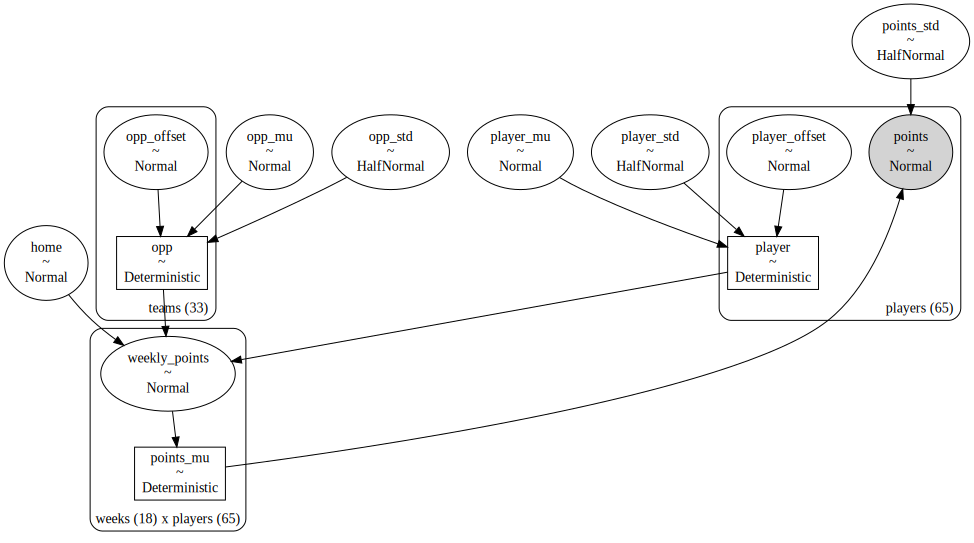

{'opp_std': -0.73,
 'opp_mu': -2.86,
 'opp_offset': -94.54,
 'player_std': -0.73,
 'player_mu': -2.86,
 'player_offset': -186.22,
 'home': -2.86,
 'weekly_points': -1075.16,
 'points_std': -0.73,
 'points': -23632.21}

In [10]:
with pm.Model(coords=coords) as model:
    # Opponent-specific parameters (non-centered format for better sampling)
    opp_std = pm.HalfNormal("opp_std", sigma=7)
    opp_mu = pm.Normal("opp_mu", mu=0, sigma=7)
    opp_offset = pm.Normal("opp_offset", mu=0, sigma=7, dims="teams")
    opp = pm.Deterministic("opp", opp_mu + opp_std * opp_offset, dims="teams")

    # Broadcast `opp` to be weeks x players
    wide_opp = opp[opp_idx]

    # Player-specific parameters (non-centered format for better sampling)
    player_std = pm.HalfNormal("player_std", sigma=7)
    player_mu = pm.Normal("player_mu", mu=0, sigma=7)
    player_offset = pm.Normal("player_offset", mu=0, sigma=7, dims=["players"])
    player = pm.Deterministic("player", player_mu + player_std * player_offset, dims=["players"])

    # Home advantage
    beta_home = pm.Normal("home", mu=0, sigma=7)
    wide_home = beta_home * home_vals  # weeks x players

    # Points scored each week is an RV centered on player traits, the opponent, and home-field advantage
    # When a team has a bye, replace the estimated weekly score with 0.0
    weekly_mu = (
        player + wide_opp + wide_home
    )  # broadcasting is OK: player is 1 x players; other two are weeks x players
    weekly_points = pm.Normal("weekly_points", mu=weekly_mu, sigma=1, dims=["weeks", "players"])
    weekly_points = at.set_subtensor(weekly_points[bye_mask], 0.0)

    # The evolution of a player's cumulative score over the season is a gaussian random walk (GRW) with drift
    points_sigma = pm.HalfNormal("points_std", sigma=7)
    points_mu = pm.Deterministic("points_mu", weekly_points.cumsum(axis=0), dims=["weeks", "players"])

    # Evalute the model likelihood based on where the GRW lands the player at the end of the season
    points = pm.Normal("points", mu=points_mu[-1, :], sigma=points_sigma, observed=proj_points, dims="players")

display(pm.model_to_graphviz(model))
model.point_logps()

In [12]:
# Sample model
with model:
    trace = pm.sample(draws=1000, tune=2000, init="jitter+adapt_diag_grad", target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [opp_std, opp_mu, opp_offset, player_std, player_mu, player_offset, home, weekly_points, points_std]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 912 seconds.
The acceptance probability does not match the target. It is 0.9839, but should be close to 0.9. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8118, but should be close to 0.9. Try to increase the number of tuning steps.


,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
opp_std,0.029,0.021,8.0,43.0,1.45
opp_mu,1.528,1.115,10.0,46.0,1.33
opp_offset[1.0],0.456,0.323,235.0,337.0,1.01
opp_offset[2.0],0.502,0.355,199.0,547.0,1.02
opp_offset[3.0],0.400,0.283,282.0,660.0,1.01
...,...,...,...,...,...
opp[29.0],1.502,1.097,10.0,57.0,1.33
opp[30.0],1.534,1.116,11.0,70.0,1.29
opp[33.0],1.434,1.042,11.0,68.0,1.29
opp[34.0],1.474,1.073,11.0,54.0,1.31


C:\Users\kmcen\Miniconda3\envs\fantasy\lib\site-packages\arviz\plots\traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (68), generating only 20 plots
  warnings.warn(


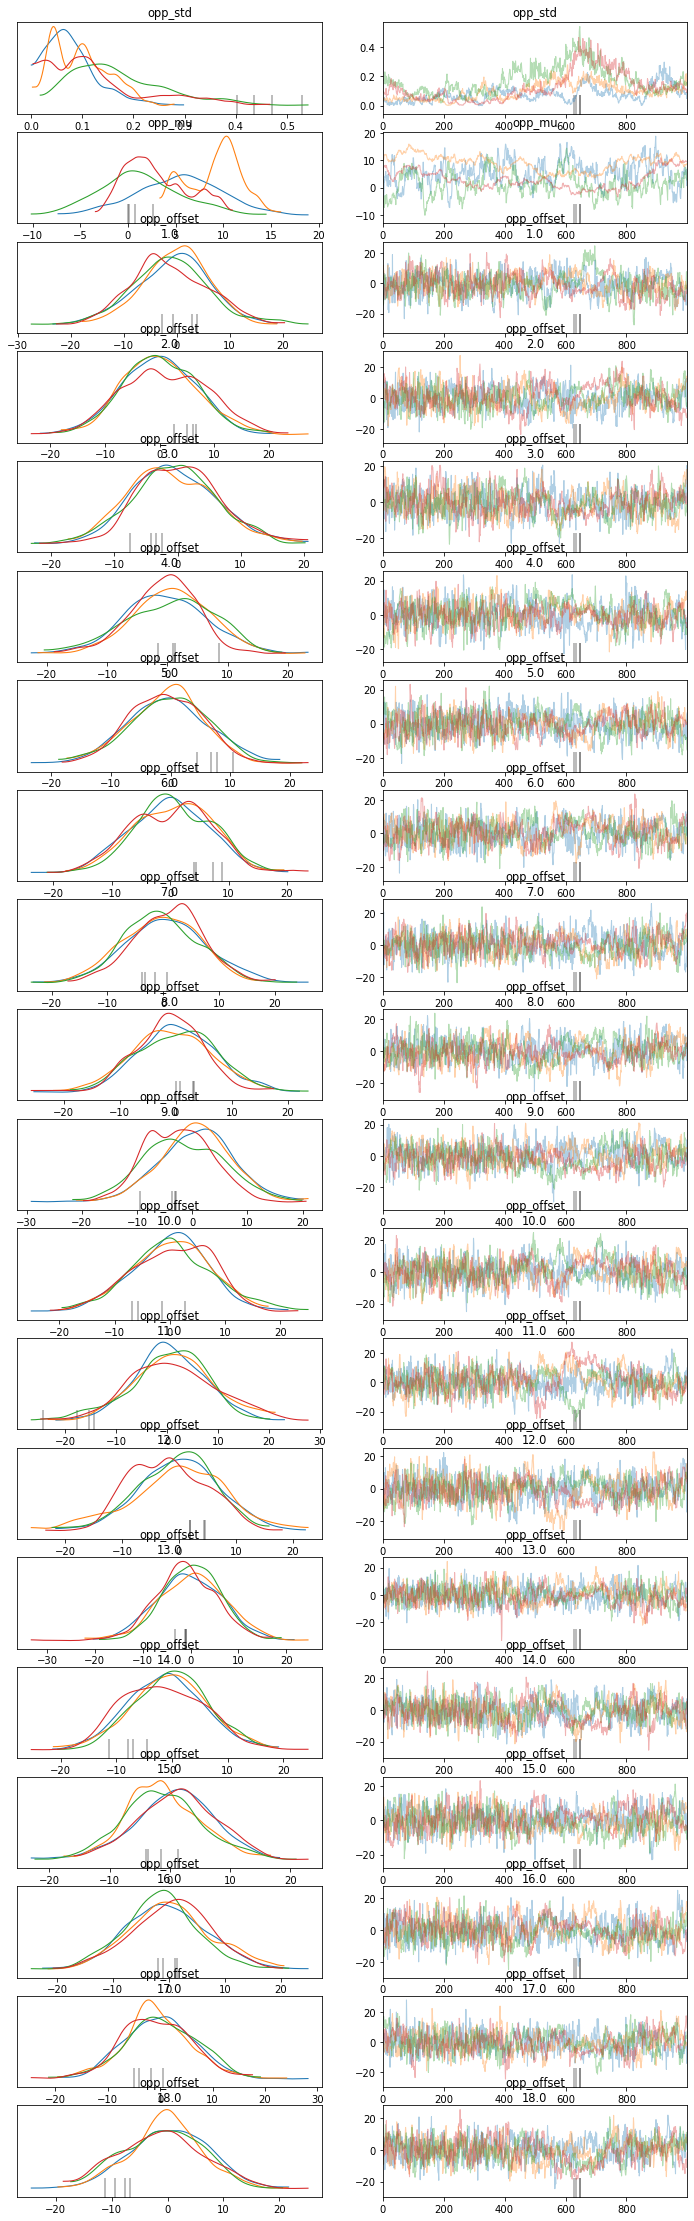

In [13]:
# Check opponent-specific parameters
trace_helper(trace, ["opp_std", "opp_mu", "opp_offset", "opp"])

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
player_std,0.015,0.011,54.0,71.0,1.07
player_mu,1.496,1.090,10.0,51.0,1.31
player_offset[2330],0.196,0.146,47.0,152.0,1.07
player_offset[8439],0.140,0.101,87.0,253.0,1.05
player_offset[11237],0.159,0.122,52.0,116.0,1.06
...,...,...,...,...,...
player[4361259],1.330,0.965,12.0,92.0,1.26
player[4362874],1.375,0.998,12.0,113.0,1.26
player[4362887],1.368,0.993,12.0,78.0,1.27
player[4383351],1.379,1.001,12.0,103.0,1.26


C:\Users\kmcen\Miniconda3\envs\fantasy\lib\site-packages\arviz\plots\traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (132), generating only 20 plots
  warnings.warn(


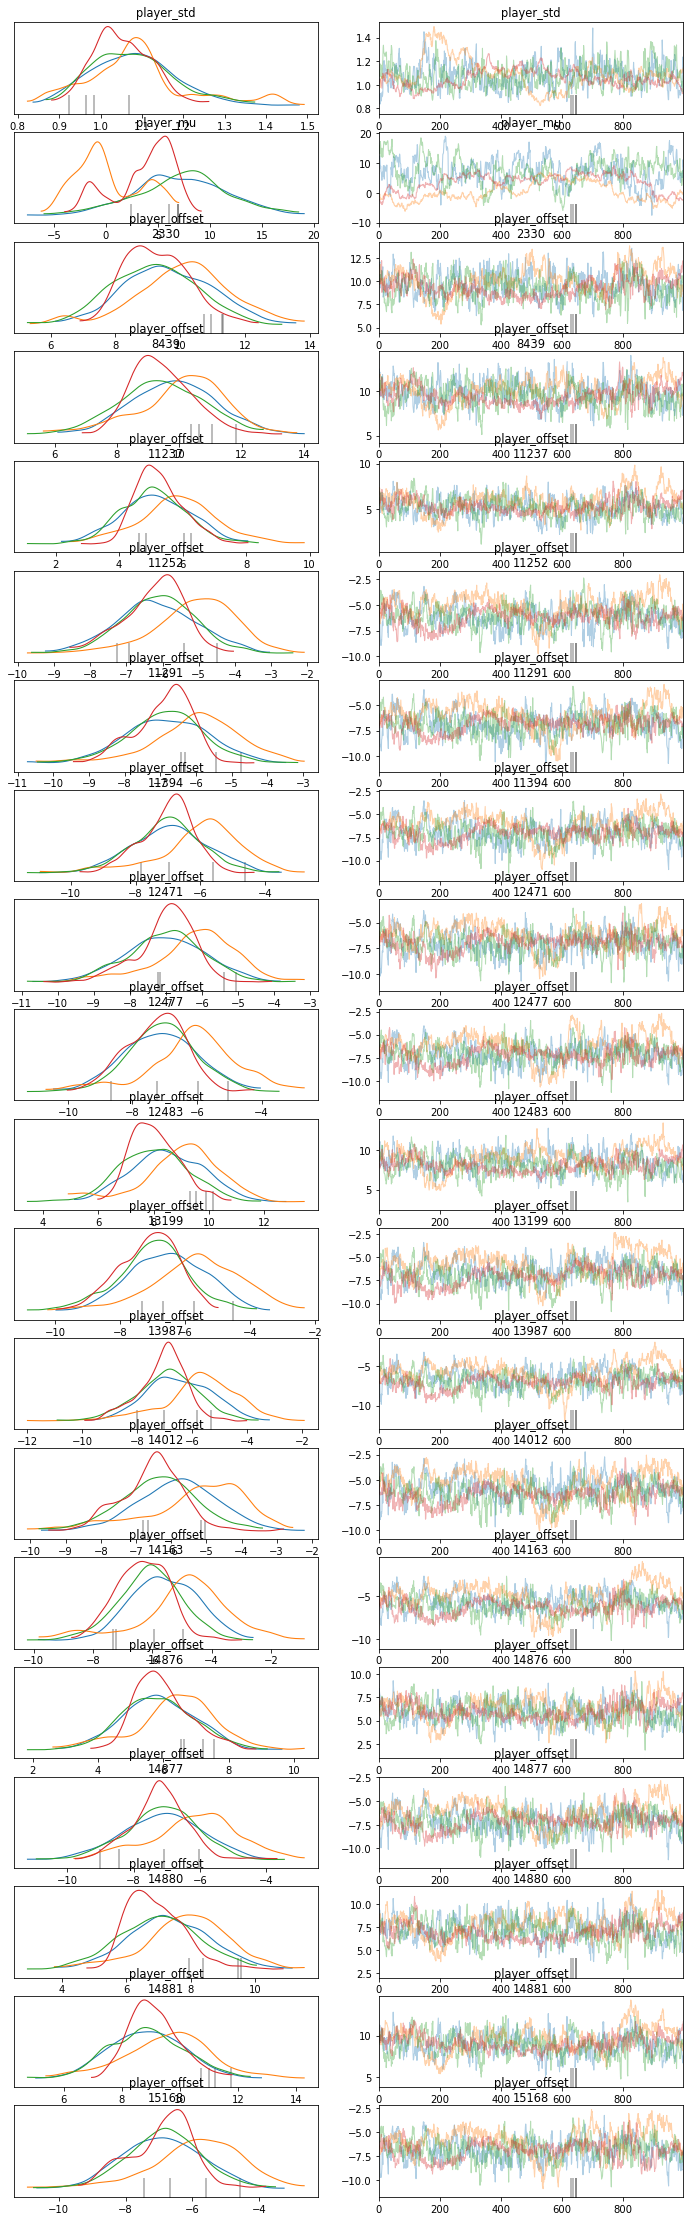

In [14]:
# Check player-specific parameters
trace_helper(trace, ["player_std", "player_mu", "player_offset", "player"])

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
home,2.287,1.724,5.0,13.0,2.26


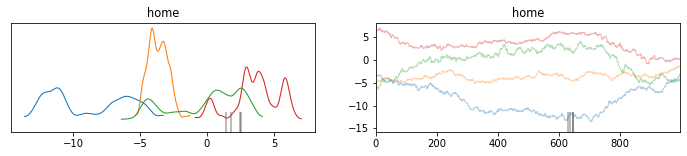

In [15]:
# Check miscellaneous parameters
trace_helper(trace, ["home"])

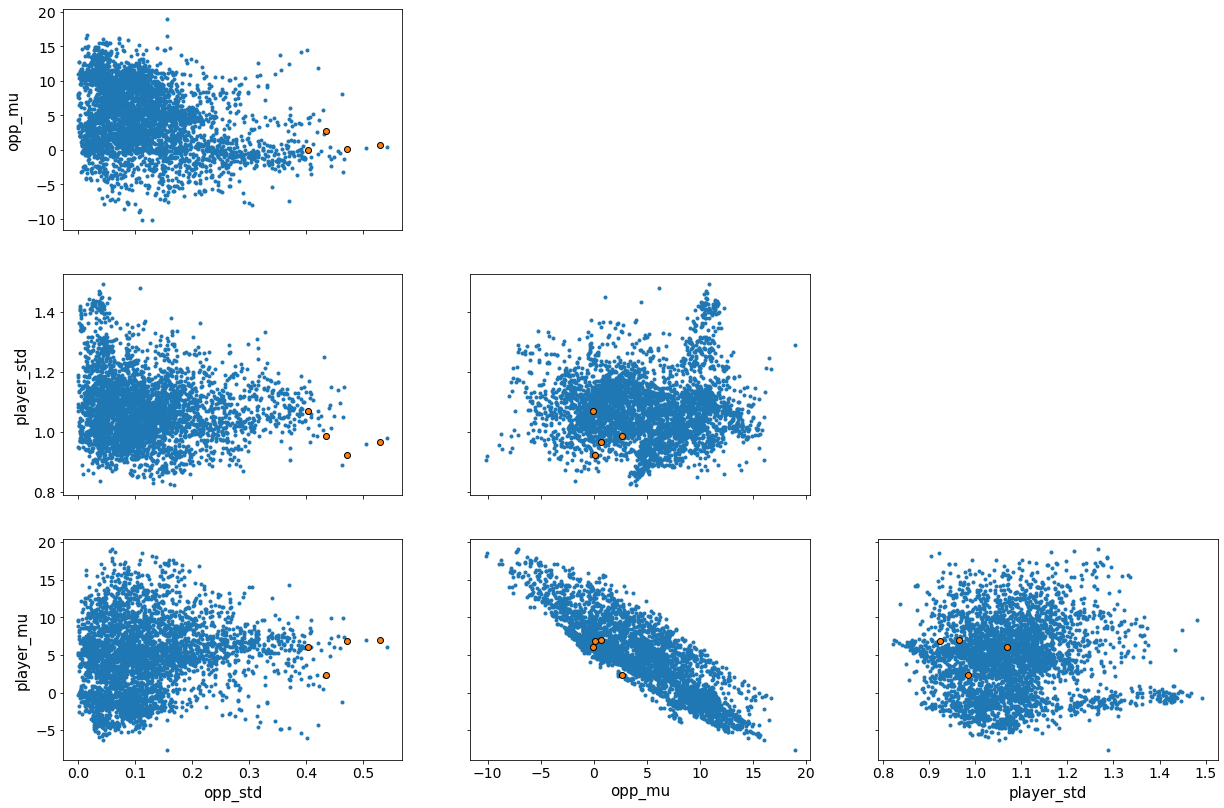

In [16]:
az.plot_pair(trace, var_names=["opp_std", "opp_mu", "player_std", "player_mu"], coords=coords, divergences=True);

In [17]:
# Get posterior predicted weekly points
posterior_weekly_points_vals = trace.posterior.weekly_points.mean(axis=0).mean(axis=0)
posterior_weekly_points = posterior_weekly_points_vals.to_dataframe()["weekly_points"]

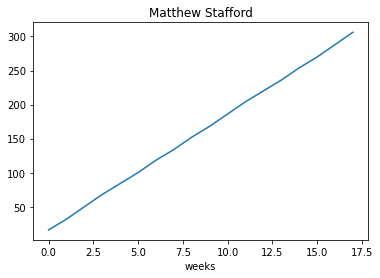

In [19]:
plot_player(posterior_weekly_points, players_map, "Matthew Stafford")